In [1]:
# Import required packages
import sys
# !{sys.executable} -m pip install seaborn
from glob import glob
import os
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from shutil import copy,move
from distutils.dir_util import copy_tree


In [2]:
def results_df(path):
    '''
    Take the top directory where the results are and return a nice Pandas dataframe

    parameters
    ----------
    path: str
        Path to the top directory `path/*/*results.json`

    returns
    -------
    df: pd.DataFrame
        Dataframe containing results
    '''
    results_dict = {}
    for i in glob(os.path.join(path,'*/*results.json')):
        with open(i,'r') as f:
            results = json.load(f)
        name = os.path.basename(i).replace('_results.json','')
        results['encoder']=name.split('_')[0]
        results['ansatz']=name.split('_')[1]
        results_dict[name]=results

    df = pd.DataFrame(results_dict).T
    
    return df



In [3]:
def plot_all(df,name,save_dir):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6), gridspec_kw={'width_ratios': [1, 1]})
    SMALL_SIZE = 8
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 12
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * 1.2)
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    
    
    sns.boxplot(data=df,x='encoder',y='value',hue='variable',ax=ax1,palette=sns.color_palette('Paired',2))
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90) 
    ax1.set_ylim(np.floor(df['value'].min()),np.ceil(df['value'].max()))
    ax1.set_ylabel('R$^{2}$')
    ax1.set_xlabel('Encoder')
    ax1.legend(title='')
    
    sns.boxplot(data=df,x='ansatz',y='value',hue='variable',ax=ax2,palette=sns.color_palette('Paired',2))
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90) 
    ax2.set_ylim(np.floor(df['value'].min()),np.ceil(df['value'].max()))
    ax2.set_ylabel('R$^{2}$')
    ax2.set_xlabel('Ansatz')
    ax2.legend(title='')
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.expanduser('~'),save_dir,f'{name}_boxplots.png'),dpi=300,bbox_inches='tight')
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,6),sharey=False)
    SMALL_SIZE = 8
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 12
    
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * 1.5)
    ax1=sns.heatmap(df[df['variable']=='Train'][["encoder", "ansatz", "value"]].pivot(index='encoder', columns='ansatz', values='value').astype(float),annot_kws={"size": 12}, square=True, annot=True, linewidth=.5,fmt='.2f',ax=ax1,vmax=1,vmin=-1,cbar=True,center=0,cmap='rocket')
    ax1.set_title("Train")
    ax1.set_ylabel('Encoder')
    ax1.set_xlabel('Ansatz')
    ax1.set_aspect("equal")
    
    ax2=sns.heatmap(df[df['variable']=='Test'][["encoder", "ansatz", "value"]].pivot(index='encoder', columns='ansatz', values='value').astype(float), annot_kws={"size": 12}, square=True, annot=True, linewidth=.5,fmt='.2f',ax=ax2,vmax=1,vmin=-1,center=0,cmap='rocket')
    ax2.set_title("Test")
    ax2.set_ylabel('Encoder')
    ax2.set_xlabel('Ansatz')
    ax2.set_aspect("equal")
    
    
    plt.subplots_adjust(wspace=0.1,hspace=0)
    plt.tight_layout()  # Leave space for color bar
    plt.savefig(os.path.join(os.path.expanduser('~'),save_dir,f'{name}_heatplots.png'),dpi=300,bbox_inches='tight')
    plt.show()

In [4]:
def plot(data_dir,name,save_dir):
    df = results_df(data_dir).rename(columns={'R2_train':'Train','R2_test':'Test'}).melt(id_vars=['encoder','ansatz'], value_vars=['Train','Test']).sort_values(by=['encoder','ansatz'])
    plot_all(df,name,save_dir)    

In [ ]:
plot("function-calc-test/sixteenqubit_test/lin16qubit/",'linear','qregress/images/Function_Fitting/sixteenqubit/')
plot("function-calc-test/sixteenqubit_test/quad16qubit/",'quadratic','qregress/images/Function_Fitting/sixteenqubit/')
plot("function-calc-test/sixteenqubit_test/sin16qubit/",'sine','qregress/images/Function_Fitting/sixteenqubit/')

In [ ]:
plot("function-calc-test/fivequbit_tests/lin5qubit/",'linear','qregress/images/Function_Fitting/fivequbit/')
plot("function-calc-test/fivequbit_tests/quad5qubit/",'quadratic','qregress/images/Function_Fitting/fivequbit/')
plot("function-calc-test/fivequbit_tests/sin5qubit/",'sine','qregress/images/Function_Fitting/fivequbit/')

In [ ]:
results_df("BSE-calc-test/5qubit/").sort_values(by=['R2_train','R2_test'])

In [ ]:
plot("BSE-calc-test/5qubit/",'BSE','qregress/images/BSE/fivequbit/')
# plot("BSE-calc-test/16qubit/",'BSE','qregress/images/BSE/sixteenqubit/')


In [ ]:
# plot("qml_DDCC/5/",'DDCC','qregress/images/DDCC/')

In [18]:
def plot_combined(df,name,save_dir):


    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6), gridspec_kw={'width_ratios': [1, 1]})
    SMALL_SIZE = 8
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 12
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * 1.2)
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    
    
    sns.boxplot(data=df,x='encoder',y='value',hue='variable',ax=ax1,palette=sns.color_palette('Paired',2))
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90) 
    ax1.set_ylim(np.floor(df['value'].min()),np.ceil(df['value'].max()))
    ax1.set_ylabel('R$^{2}$')
    ax1.set_xlabel('Encoder')
    ax1.legend(title='')
    
    sns.boxplot(data=df,x='ansatz',y='value',hue='variable',ax=ax2,palette=sns.color_palette('Paired',2))
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90) 
    ax2.set_ylim(np.floor(df['value'].min()),np.ceil(df['value'].max()))
    ax2.set_ylabel('R$^{2}$')
    ax2.set_xlabel('Ansatz')
    ax2.legend(title='')
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.expanduser('~'),save_dir,f'{name}_boxplots.png'),dpi=300,bbox_inches='tight')
    plt.show()    

In [14]:
concatfive = pd.concat([results_df("function-calc-test/fivequbit_tests/lin5qubit/"),results_df("function-calc-test/fivequbit_tests/quad5qubit/"),results_df("function-calc-test/fivequbit_tests/sin5qubit/")]).rename(columns={'R2_train':'Train','R2_test':'Test'}).melt(id_vars=['encoder','ansatz'], value_vars=['Train','Test']).sort_values(by=['encoder','ansatz'])

In [48]:
lin5 = results_df("function-calc-test/fivequbit_tests/lin5qubit/").rename(columns={'R2_train':'Train','R2_test':'Test'}).melt(id_vars=['encoder','ansatz'], value_vars=['Train','Test']).sort_values(by=['encoder','ansatz'])
quad5 = results_df("function-calc-test/fivequbit_tests/quad5qubit/").rename(columns={'R2_train':'Train','R2_test':'Test'}).melt(id_vars=['encoder','ansatz'], value_vars=['Train','Test']).sort_values(by=['encoder','ansatz'])
sin5 = results_df("function-calc-test/fivequbit_tests/sin5qubit/").rename(columns={'R2_train':'Train','R2_test':'Test'}).melt(id_vars=['encoder','ansatz'], value_vars=['Train','Test']).sort_values(by=['encoder','ansatz'])

In [86]:
results_df("function-calc-test/fivequbit_tests/sin5qubit/")[(results_df("function-calc-test/fivequbit_tests/sin5qubit/")['R2_train']>=0.88)&(results_df("function-calc-test/fivequbit_tests/sin5qubit/")['R2_test']>=0.88)].sort_values(by=['R2_test','R2_train'])

,MSE_train,R2_train,MAE_train,MSE_test,R2_test,MAE_test,encoder,ansatz
A1-A1-CZ_Full-CRX,[0.05933503589100011],0.88185,0.199507,0.052012,0.902999,0.196938,A1-A1-CZ,Full-CRX
M-M-CZ_Full-CRX,[0.05591891770655664],0.888652,0.194082,0.049302,0.908053,0.197705,M-M-CZ,Full-CRX


In [87]:
sorted([(i,f"{sin5[sin5['encoder']==i]['value'].astype(float).mean():.4f}") for i in set(sin5['encoder'])],key=lambda x: x[1])

[('A2-A2-CZ', '0.0683'),
 ('A2-A2-CNOT', '0.0942'),
 ('A1-A1-CNOT', '0.1046'),
 ('M-M-CNOT', '0.1096'),
 ('M-A2-CNOT', '0.1107'),
 ('M-A1-CNOT', '0.1509'),
 ('M-M-CZ', '0.2208'),
 ('A2', '0.3545'),
 ('A1', '0.3894'),
 ('A1-A1-CZ', '0.4780'),
 ('IQP', '0.5373'),
 ('M-A1-CZ', '0.5997'),
 ('M-A2-CZ', '0.6168'),
 ('M', '0.6456')]

In [88]:
sorted([(i,f"{sin5[sin5['ansatz']==i]['value'].astype(float).mean():.4f}") for i in set(sin5['ansatz'])],key=lambda x: x[1])

[('Modified-Pauli-CRZ', '0.0481'),
 ('Full-CRZ', '0.0497'),
 ('Efficient-CRZ', '0.0520'),
 ('Efficient-CRX', '0.0630'),
 ('ESU2', '0.1178'),
 ('Hadamard', '0.2640'),
 ('Full-Pauli-CRZ', '0.4574'),
 ('HWE-CZ', '0.4659'),
 ('Modified-Pauli-CRX', '0.4920'),
 ('Full-Pauli-CRX', '0.5021'),
 ('HWE-CNOT', '0.5732'),
 ('Full-CRX', '0.7551')]

/tmp/ipykernel_118974/4140320995.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/tmp/ipykernel_118974/4140320995.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


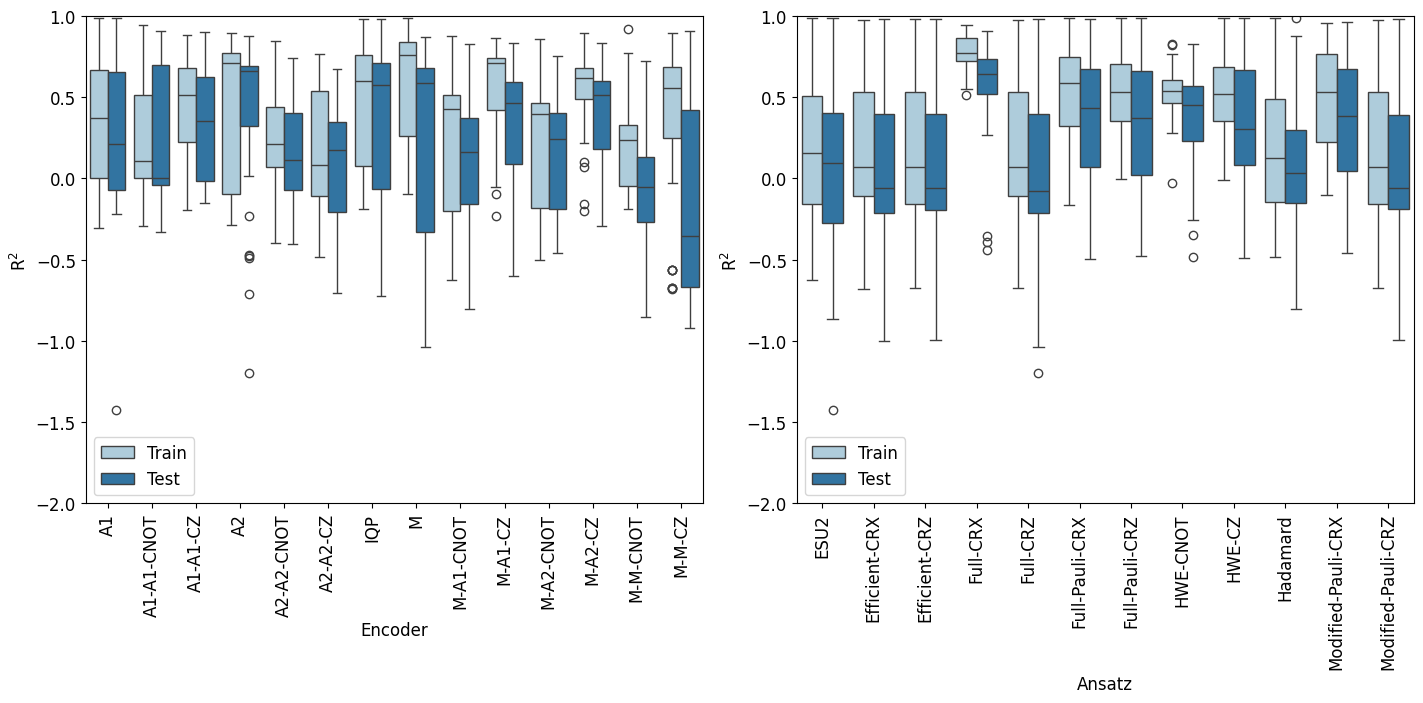

In [19]:
plot_combined(concatfive,'five_feature_function_fitting','qregress/images/Function_Fitting/fivequbit/')

In [42]:
concatsixteen = pd.concat([results_df("function-calc-test/sixteenqubit_test/lin16qubit/"),results_df("function-calc-test/sixteenqubit_test/quad16qubit//"),results_df("function-calc-test/sixteenqubit_test/sin16qubit/")]).rename(columns={'R2_train':'Train','R2_test':'Test'}).melt(id_vars=['encoder','ansatz'], value_vars=['Train','Test']).sort_values(by=['encoder','ansatz'])

In [43]:
sorted([(i,f"{concatsixteen[concatsixteen['encoder']==i]['value'].astype(float).mean():.4f}") for i in set(concatsixteen['encoder'])],key=lambda x: x[1])

[('M-M-CZ', '-0.0008'),
 ('M-M-CNOT', '-0.0404'),
 ('A2-A2-CZ', '0.0574'),
 ('M-A1-CNOT', '0.0919'),
 ('A2-A2-CNOT', '0.1035'),
 ('M-A2-CNOT', '0.1314'),
 ('A1-A1-CNOT', '0.1586'),
 ('A1', '0.2293'),
 ('A1-A1-CZ', '0.2597'),
 ('M', '0.3414'),
 ('A2', '0.3459'),
 ('M-A1-CZ', '0.3937'),
 ('M-A2-CZ', '0.4098'),
 ('IQP', '0.4506')]

In [44]:
sorted([(i,f"{concatsixteen[concatsixteen['ansatz']==i]['value'].astype(float).mean():.4f}") for i in set(concatsixteen['ansatz'])],key=lambda x: x[1])

[('HWE-CNOT', '-0.0695'),
 ('Hadamard', '0.1252'),
 ('Efficient-CRX', '0.1432'),
 ('Full-CRZ', '0.1432'),
 ('Full-CRX', '0.1432'),
 ('Efficient-CRZ', '0.1432'),
 ('Modified-Pauli-CRZ', '0.1432'),
 ('ESU2', '0.1789'),
 ('Modified-Pauli-CRX', '0.3624'),
 ('HWE-CZ', '0.3742'),
 ('Full-Pauli-CRX', '0.3867'),
 ('Full-Pauli-CRZ', '0.4393')]

/tmp/ipykernel_118974/4140320995.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/tmp/ipykernel_118974/4140320995.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


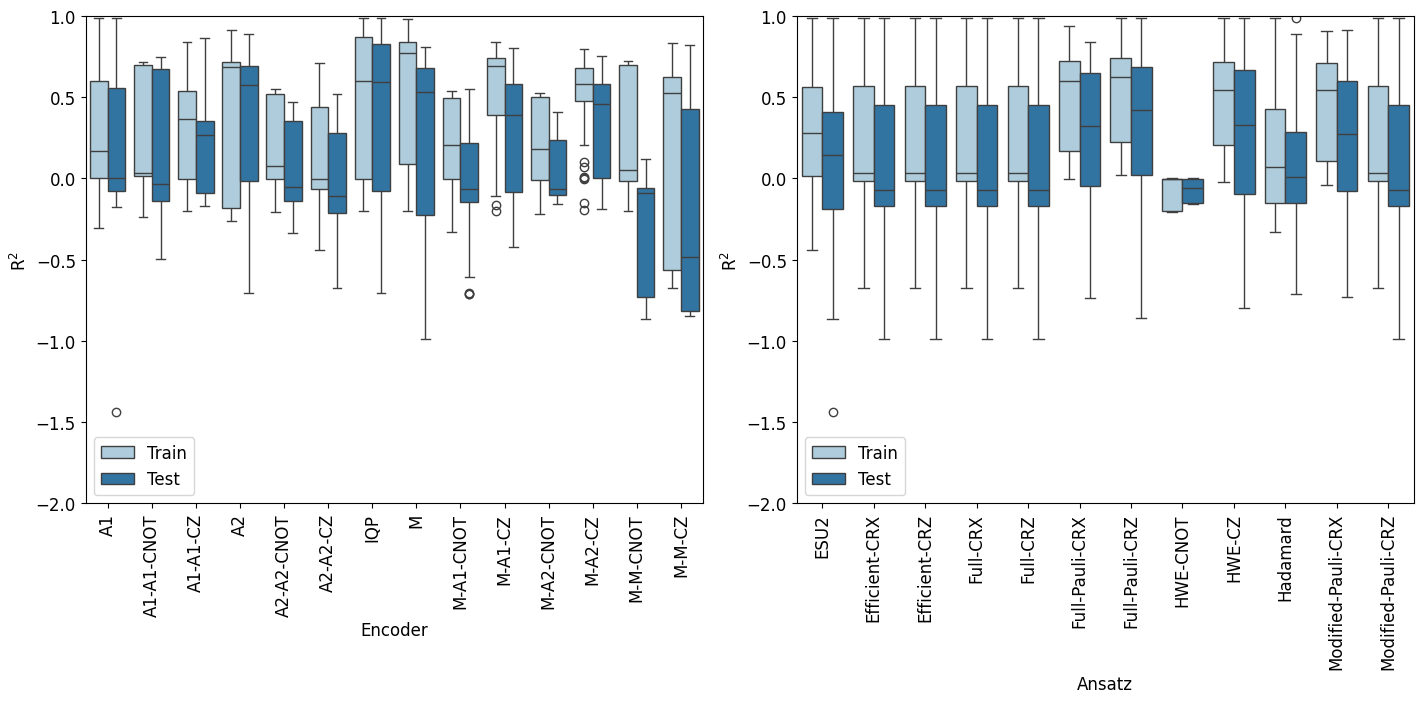

In [45]:
plot_combined(concatsixteen,'sixteen_feature_function_fitting','qregress/images/Function_Fitting/sixteenqubit/')

In [ ]:
'images/Function_Fitting/sixteenqubit/sixteen_feature_function_fitting_boxplots.png'